In [2]:
from geomodel_optimizer import LocationOptimizer

Define a work directory where all inputs and outputs will be organized

In [3]:
workdir = "./run_example"

Create a LocationOptimizer instance. All inputs will be copied into the `inputs` subdirectory of the work directory

In [4]:
opt = LocationOptimizer(
    base_input="inputs/base_params.json",
    mesh_path_h5="inputs/variable_permeability.h5",
    mesh_path_exo="inputs/variable_permeability.exo",
    initial_state_path="inputs/production_test.h5",
    workdir=workdir
)

If the base input parameters file is the same as the one used to compute the natural state, it may have different time steps than what is required of the optimization process. 

This step has to be performed before outputting any files (described later)

In [5]:
opt.adjust_timesteps(step_size=opt.YEAR_IN_SECONDS, n_steps=50)

For this test we want a permanent reinjection well placed at X, Y, Z = 1200, 1200, -1500. The location can be passed with the `location` argument as a size 3 tuple or using the `cell` argument as an integer. For a reinjection well we specify the enthalpy as well. The rate parameter is in kg/s

In [6]:
opt.permanent_source(location=[1200, 1200, -1500], rate=100, enthalpy=160e3)

True

We will be testing every location defined in the `inputs/sink_locations.txt` file. Alternatively the locations could be supplied with a list of integers with the `cells` argument.

In [7]:
opt.moving_sink(coordinates_file="inputs/sink_locations.txt", rate=-100)

If you want to inspect the input files before running, you can output them with the `output_run_files` method. This method is automatically called with the `execute` method, so this step is optional.

In [8]:
opt.output_run_files()

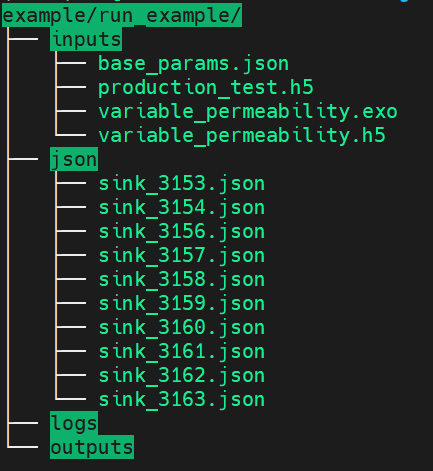

To perform all the Waiwera runs, run the `execute` method.

In [9]:
opt.execute()

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:07<00:00, 24.72s/it]


At this point the `outputs` and `logs` directories should be populated by the Waiwera results. The LocationOptimizer instance contains the results as well:

In [10]:
opt.runs

[WaiweraRun [sink_3153],
 WaiweraRun [sink_3154],
 WaiweraRun [sink_3156],
 WaiweraRun [sink_3157],
 WaiweraRun [sink_3158],
 WaiweraRun [sink_3159],
 WaiweraRun [sink_3160],
 WaiweraRun [sink_3161],
 WaiweraRun [sink_3162],
 WaiweraRun [sink_3163]]

The WaiweraRun class contains some helpful methods to work with the outputs

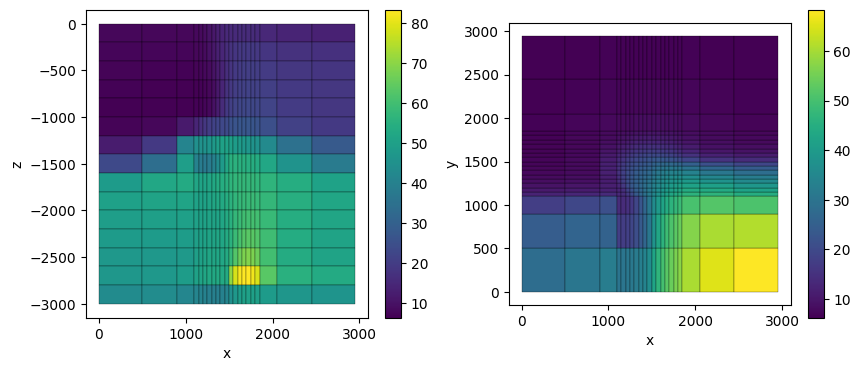

In [11]:
opt.runs[0].plots(depth=5)

To evaluate the runs, a metric must be chosen and a function defined that calculates a numerical value for that metric. A convenient way to do this is to define a function that takes a `WaiweraRun` instance as input. The following function calculates the total energy extracted over the simulation period:

In [12]:
def total_energy(run: 'WaiweraRun') -> float:
    specific_heat = 4000
    final_temperature = 40
    
    sink_idx = run.meta["sink_idx"]
    sink_rate = abs(run.meta["sink_rate"])
    with run.open() as data:
        timesteps = [s for s in data["time"]]

    total = 0
    for step, t_seconds in enumerate(timesteps):
        temperature = run.get_temperature(run.h5_path, step)
        temp_at_sink = temperature[sink_idx]
        delta_t = temp_at_sink - final_temperature
        delta_t = max(0, delta_t) # assume a stop of extraction if borehole cools below final_temperature
        energy = sink_rate * t_seconds * delta_t * specific_heat
        total += energy
    return total[0]

Supply the function to the `compute_loss` method

In [13]:
opt.compute_loss(total_energy)

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.46s/it]


The results are added to a DataFrame containing metadata

In [14]:
opt.meta.head()

,sink_idx,sink_rate,sink_name,sink_component,json_file,run_index,run_name,loss,sink_x,sink_y,sink_z
0,3153,-100,sink_3153,water,run_example\json\sink_3153.json,0,sink_3153,4.618141e+16,1125.0,1125.0,-1500.0
1,3154,-100,sink_3154,water,run_example\json\sink_3154.json,1,sink_3154,3.978344e+16,1175.0,1125.0,-1500.0
2,3156,-100,sink_3156,water,run_example\json\sink_3156.json,2,sink_3156,4.990836e+16,1275.0,1125.0,-1500.0
3,3157,-100,sink_3157,water,run_example\json\sink_3157.json,3,sink_3157,7.071008e+16,1325.0,1125.0,-1500.0
4,3158,-100,sink_3158,water,run_example\json\sink_3158.json,4,sink_3158,8.907561e+16,1375.0,1125.0,-1500.0


To see which locations yielded the most energy we can sort by loss

In [15]:
opt.meta.sort_values("loss", ascending=False)[["loss", "sink_idx", "sink_x", "sink_y", "sink_z"]]

,loss,sink_idx,sink_x,sink_y,sink_z
9,2.274798e+17,3163,1625.0,1125.0,-1500.0
8,1.980524e+17,3162,1575.0,1125.0,-1500.0
7,1.558813e+17,3161,1525.0,1125.0,-1500.0
6,1.130963e+17,3160,1475.0,1125.0,-1500.0
5,1.028778e+17,3159,1425.0,1125.0,-1500.0
4,8.907561e+16,3158,1375.0,1125.0,-1500.0
3,7.071008e+16,3157,1325.0,1125.0,-1500.0
2,4.990836e+16,3156,1275.0,1125.0,-1500.0
0,4.618141e+16,3153,1125.0,1125.0,-1500.0
1,3.978344e+16,3154,1175.0,1125.0,-1500.0
